<a href="https://colab.research.google.com/github/ellie456789/STA365HW/blob/main/HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# question1

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('drive/MyDrive/housing.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Output()


Posterior Summary (Mean & 94% HDI):
intercept: Mean = 0.000, 94% HDI = [-0.050, 0.050]
median_income: Mean = 0.597, 94% HDI = [0.540, 0.653]
housing_median_age: Mean = 0.080, 94% HDI = [0.021, 0.140]
total_rooms: Mean = 0.104, 94% HDI = [0.014, 0.194]
total_bedrooms: Mean = -0.008, 94% HDI = [-0.095, 0.076]
ocean_proximity_INLAND: Mean = -0.271, 94% HDI = [-0.329, -0.213]
ocean_proximity_NEAR BAY: Mean = 0.055, 94% HDI = [-0.000, 0.110]
ocean_proximity_NEAR OCEAN: Mean = 0.167, 94% HDI = [0.113, 0.220]


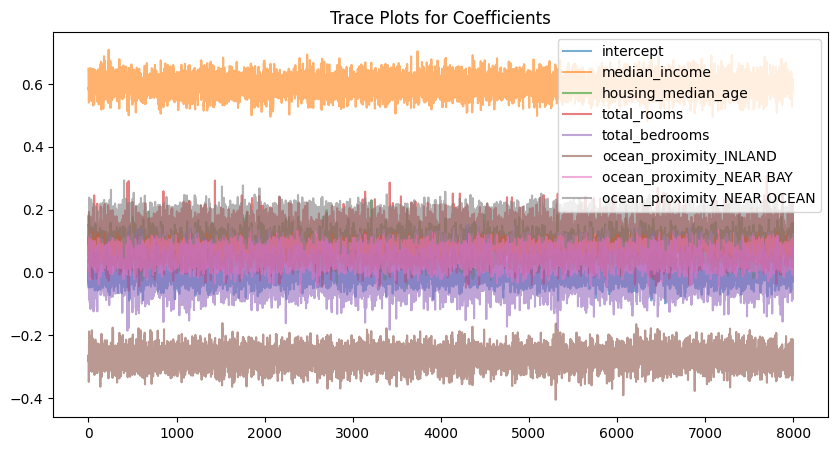

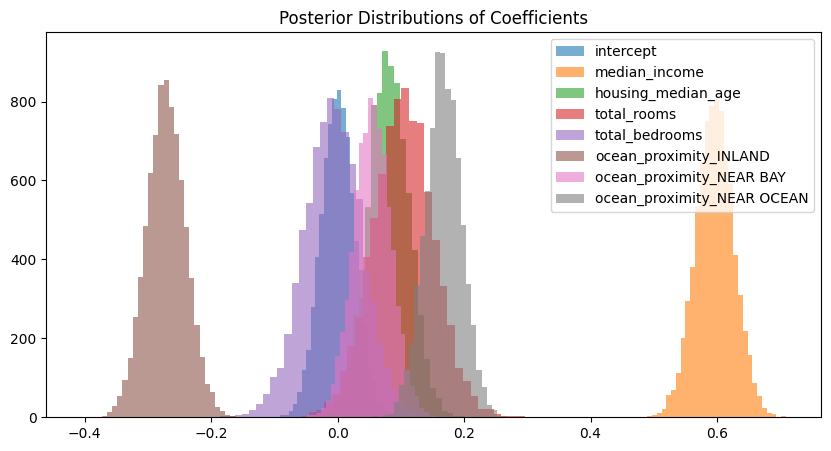

In [9]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

data_sample = data.sample(n=500, random_state=42)


data_sample['total_bedrooms'] = data_sample['total_bedrooms'].fillna(data_sample['total_bedrooms'].median())
data_sample['ocean_proximity'] = data_sample['ocean_proximity'].astype('category')
data_sample = pd.get_dummies(data_sample, columns=['ocean_proximity'], drop_first=True)

# Define features and target variable
feature_names = ['median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms'] + \
                [col for col in data_sample.columns if 'ocean_proximity' in col]

X = data_sample[feature_names]
y = data_sample['median_house_value']

# Normalize
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# intercept
X_scaled = np.c_[np.ones(X_scaled.shape[0]), X_scaled]
feature_names = ['intercept'] + feature_names  # Add intercept name

# Number of predictors
p = X_scaled.shape[1]

# Bayesian Linear Regression Model
with pm.Model() as model:
    # Priors for regression coefficients
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model
    mu = pm.math.dot(X_scaled, betas)

    # Likelihood
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=y_scaled)

    # MCMC sampling
    trace = pm.sample(2000, tune=1000, chains=4, target_accept=0.95, random_seed=42)

trace_dict = {var: trace.posterior[var].values for var in trace.posterior.data_vars}

# Summary statistics
print("\nPosterior Summary (Mean & 94% HDI):")
for i, var in enumerate(feature_names):
    samples = trace_dict['betas'][:, :, i].flatten()
    mean = np.mean(samples)
    hdi_low, hdi_high = np.percentile(samples, [3, 97])  # 94% HDI
    print(f"{var}: Mean = {mean:.3f}, 94% HDI = [{hdi_low:.3f}, {hdi_high:.3f}]")

# Trace plots for posterior samples
plt.figure(figsize=(10, 5))
for i, var in enumerate(feature_names):
    plt.plot(trace_dict['betas'][:, :, i].flatten(), alpha=0.6, label=var)
plt.legend()
plt.title("Trace Plots for Coefficients")
plt.show()

# Histogram of posterior samples
plt.figure(figsize=(10, 5))
for i, var in enumerate(feature_names):
    plt.hist(trace_dict['betas'][:, :, i].flatten(), bins=30, alpha=0.6, label=var)
plt.legend()
plt.title("Posterior Distributions of Coefficients")
plt.show()


# Question2